In [1]:
# Imports
import gc
import numpy as np
import cv2
import pandas as pd
import random
from keras.models import Sequential
from keras.models import model_from_json
import os
import matplotlib.pyplot as plt
import skimage.feature
import keras
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.training_utils import multi_gpu_model
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D
from keras.utils import np_utils
import sys
%matplotlib inline

c:\users\vincenzo\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# We define in advance constants to build the model

INPUT_SHAPE = (96, 96, 3)
OUTPUT_SIZE = 1

LEARNING_RATE = 0.0001
OPTIMIZER = keras.optimizers.Adam()
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

EPOCHS = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50

MODEL_PATH = "./binary_classifier/net_0_model.json"
WEIGHTS_PATH = "./binary_classifier/net_0_weights.h5"

In [3]:
# Use a random seed
random.seed(42)

In [4]:
# Load patches for sea lions
def extract_patches(path, size, label):
    data_set = []
    for file in range(0, size):
        patch = cv2.imread("./patches/" + path + "/" + str(file) + ".jpg")
        data_set.append(list((patch, label)))
    return data_set

In [5]:
# Extract train patches
data_set_sea_lions_train = extract_patches("sealions_train", 62652, "sea lion")
data_set_background_train = extract_patches("background_train", 62652, "background")

In [6]:
# Build train set
train_set = data_set_sea_lions_train + data_set_background_train
random.shuffle(train_set)
X_train = []
Y_train = []
print(sys.getsizeof(X_train))
for data in train_set:
    X_train.append(data[0])
    if data[1] == "sea lion":
        Y_train.append([1])
    elif data[1] == "background":
        Y_train.append([0])
X_train = np.array(X_train, copy=False)
print(sys.getsizeof(X_train))
Y_train = np.array(Y_train, copy=False)

# Free memory
data_set_sea_lions_train = []
data_set_background_train = []
train_set = []
gc.collect()

# Convert data types and normalize values
X_train = X_train.astype('float32')
print(sys.getsizeof(X_train))
X_train /= 255

In [7]:
# Build parallel model (multi gpu)

model = Sequential()
# First layer
model.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth layer
model.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

In [8]:
# Train (multi gpu)

# Fit model on training data
history = parallel_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, verbose=1)


Train on 100243 samples, validate on 25061 samples
Epoch 1/20
100243/100243 [==============================] - 76s 757us/step - loss: 0.3756 - acc: 0.8473 - val_loss: 0.4700 - val_acc: 0.7633
Epoch 2/20
100243/100243 [==============================] - 64s 639us/step - loss: 0.2439 - acc: 0.9093 - val_loss: 0.4389 - val_acc: 0.7751
Epoch 3/20
100243/100243 [==============================] - 64s 637us/step - loss: 0.2307 - acc: 0.9140 - val_loss: 0.4944 - val_acc: 0.7145
Epoch 4/20
100243/100243 [==============================] - 64s 639us/step - loss: 0.2244 - acc: 0.9163 - val_loss: 0.4544 - val_acc: 0.7420
Epoch 5/20
100243/100243 [==============================] - 63s 632us/step - loss: 0.2178 - acc: 0.9196 - val_loss: 0.6601 - val_acc: 0.5968
Epoch 6/20
100243/100243 [==============================] - 64s 643us/step - loss: 0.2155 - acc: 0.9195 - val_loss: 0.5805 - val_acc: 0.6730
Epoch 7/20
100243/100243 [==============================] - 65s 644us/step - loss: 0.2129 - acc: 0.9205

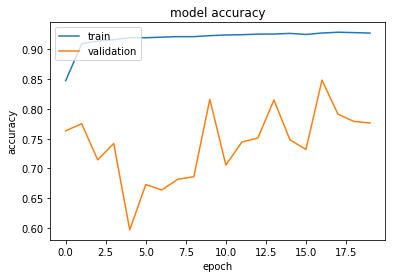

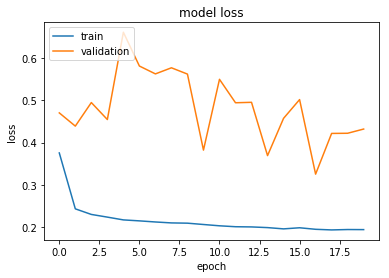

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# Save trained model (multi gpu)

# serialize model to JSON
# model_json = parallel_model.to_json()
# with open(MODEL_PATH, "w") as json_file:
#     json_file.write(model_json)
# serialize weights to HDF5
parallel_model.save_weights(WEIGHTS_PATH)

# Free memory
X_train = []
Y_train = []
gc.collect()

11965

In [10]:
# Extract test patches

data_set_sea_lions_test = extract_patches("sealions_test", 17634, "sea lion")
data_set_background_test = extract_patches("background_test", 17634, "background")

In [11]:
# Build test set
test_set = data_set_sea_lions_test + data_set_background_test
random.shuffle(test_set)
X_test = []
Y_test = []
for data in test_set:
    X_test.append(data[0])
    if data[1] == "sea lion":
        Y_test.append([1])
    elif data[1] == "background":
        Y_test.append([0])
X_test = np.array(X_test, copy=False)
Y_test = np.array(Y_test, copy=False)

# Free memory
data_set_sea_lions_test = []
data_set_background_test = []
test_set = []
gc.collect()

# Convert data types and normalize values
X_test = X_test.astype('float32')
X_test /= 255

In [12]:
# Test (multi gpu)

# Evaluate model on test data
loss_and_metrics = parallel_model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=1)

print("%s: %.2f%%" % (parallel_model.metrics_names[1], loss_and_metrics[1]*100))

35268/35268 [==============================] - 10s 273us/step
acc: 88.67%


In [13]:
# Evaluate ROC and AUC

Y_pred = parallel_model.predict(X_test)
roc_auc_score(Y_test, Y_pred)

0.9797711937301261

In [14]:
# Free memory
X_test = []
Y_test = []
gc.collect()